In [1]:
import csv
import glob
import os
import re

In [2]:
from collections import defaultdict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
gene_cat = dict()

In [5]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, gene_func, *_ = row

        if gene_func == "protein_coding":
            gene_cat[gene] = {gene_func}

In [6]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, pos, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, _ = meta_exon.split("=")
        if exon_type == "FE":
            gene_cat[gene].add("gained_ss")

In [7]:
name2tis = dict()

In [8]:
with open("../data/lin2014/meta_data.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        tis, *_, path = row

        if path:
            name = re.search(r'ENC\w+', path).group(0)
            name2tis[name] = tis

In [9]:
gene_tpm = defaultdict(dict)

In [10]:
for path in glob.iglob("data/lin2014/gene_tpm/*.tsv"):
    name = os.path.basename(path).removesuffix(".tsv")
    tis = name2tis[name]

    with open(path, 'r') as f:
        reader = csv.DictReader(f, delimiter="\t")

        for row in reader:
            gene = row['gene_id']
            tpm = float(row['TPM'])

            if gene.startswith("ENS"):
                gene, _ = gene.split(".")
            else:
                continue

            if gene in gene_cat and tpm > 0:
                gene_tpm[tis][gene] = np.log1p(tpm)

In [11]:
long_data = list()

In [12]:
for tis in gene_tpm:
    for gene, tpm in gene_tpm[tis].items():
        long_data.append({
            'cat': "protein_coding",
            'tis': tis,
            'tpm': tpm
        })

        if "gained_ss" in gene_cat[gene]:
            long_data.append({
                'cat': 'gained_ss',
                'tis': tis,
                'tpm': tpm
            })

In [13]:
frame = pd.DataFrame(long_data)

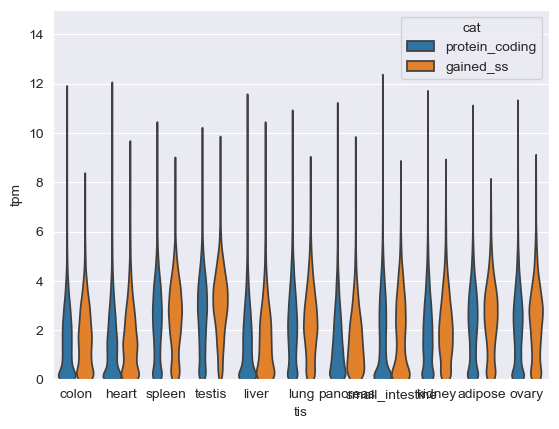

In [14]:
sns.violinplot(
    frame,
    x='tis',
    y='tpm',
    hue='cat',
    inner=None,
    order=["colon", "heart", "spleen", "testis", "liver", "lung", "pancreas", "small_intestine", "kidney", "adipose", "ovary"]
)

_ = plt.ylim(0, 15)
plt.savefig("figs/supp3b.pdf")